# Проект: Анализ данных для сервиса аренды самокатов Go Fast

Для анализа предоставлены данные сервиса аренды самокатов GoFast, которые включают данные о некоторых пользователях из нескольких городов, а также об их поездках. 

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки
 - абонентская плата отсутствует;
 - стоимость одной минуты поездки — 8 рублей;
 - стоимость старта (начала поездки) — 50 рублей;

* с подпиской Ultra
 - абонентская плата — 199 рублей в месяц;
 - стоимость одной минуты поездки — 6 рублей;
 - стоимость старта — бесплатно.

# Описание данных

**Пользователи** — users_go.csv
* user_id - уникальный идентификатор пользователя
* name -	имя пользователя
* age -	возраст
* city - город
* subscription_type - тип подписки (free, ultra)

**Поездки** — rides_go.csv
* user_id - уникальный идентификатор пользователя
* distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
* duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* date - дата совершения поездки

**Подписки** — subscriptions_go.csv
* subscription_type - тип подписки
* minute_price - стоимость одной минуты поездки по данной подписке
* start_ride_price - стоимость начала поездки
* subscription_fee - стоимость ежемесячного платежа

Нам предстоит проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom
from math import sqrt

## Получаем общую информацию о данных

In [5]:
try:
        users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
        rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
        subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
except:
        users = pd.read_csv('/datasets/users_go.csv')
        rides = pd.read_csv('/datasets/rides_go.csv')
        subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

### Таблица users - пользователи

In [7]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [9]:
users.shape

(1565, 5)

Датафрейм "users" содержит информацию о пользователях сервиса аренды самокатов. Хранит 1565 записей в 5 колонках.

<div class="alert alert-block alert-info">
Названия столбцов корректны, пропусков нет, тип данных соответствует ожидаемому
</div>

### Таблица rides - поездки

In [12]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [13]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [14]:
rides.shape

(18068, 4)

<a id='right_here'></a>

In [16]:
print(rides['date'].min())
print(rides['date'].max())

2021-01-01
2021-12-30


Датафрейм "rides" содержит информацию о поездках, совершенных пользователями сервиса в период с января по декабрь 2021 года. Хранит 18068 записей в 4 колонках. 
<div class="alert alert-block alert-info">
Названия столбцов корректны, пропусков нет, данные в столбце date имеют тип object - нужно будет скорректировать.
</div>

### Таблица subscriptions - подписки

In [19]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [20]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


In [21]:
subscriptions.shape

(2, 4)

Таблица subscriptions содержит информацию о типах подписок сервиса. 

<div class="alert alert-block alert-info">
Названия столбцов корректны, пропусков нет, тип данных соответствует ожидаемому.
</div>

## Предобработка данных

### Изменим формат столбца date таблицы rides
Для дальнейшей работы переведем столбец date, содержащий дату, в формат datetime.

In [27]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

### Добавим столбец с номером месяца

Создадим новый столбец 'month', содержащий номер месяца, в таблице rides.

In [30]:
rides['month'] = rides['date'].dt.month

### Обработаем дубликаты

Проверим таблицы users и rides на наличие явных дубликатов. 

In [36]:
users.duplicated().sum()

31

In [37]:
# удалим дубликаты
users = users.drop_duplicates()

In [38]:
users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

In [39]:
rides.duplicated().sum()

0

### Проверим пропущенные значения

In [41]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [42]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [43]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Проведена предобработка данных:
* В таблице **users**:
  - удалена 31 дублирующая строка;
  - пропущенные значения отсутствуют.
* В таблице **rides**:
  - формат столбца 'date' изменен на datetime для удобства работы с датами;
  - добавлен столбец 'month' с номером месяца;
  - дубликатов не обнаружено;
  - пропущенные значения отсутствуют.
* В таблице **subscriptions**:
  - пропущенные значения отсутствуют.

## Исследовательский анализ данных

### Частота встречаемости городов

Сводная таблица "users_city" содержит название города, количество пользователей сервиса в городе и относительную частоту встречаемости города в процентах.

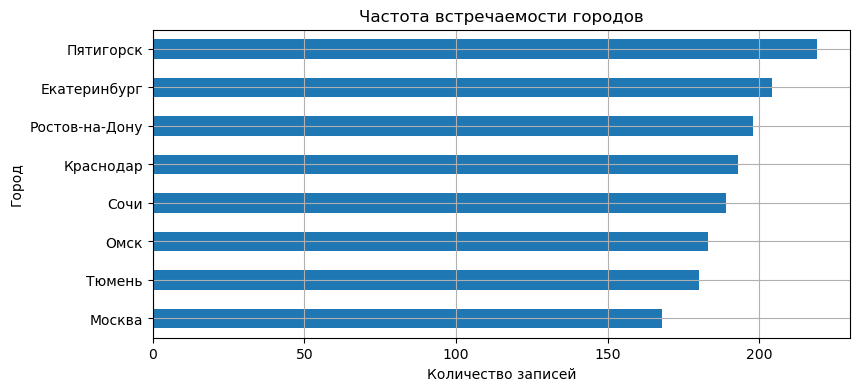

In [50]:
users['city'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(9, 4), grid=True)
plt.title('Частота встречаемости городов')
plt.xlabel('Количество записей')
plt.ylabel('Город')
plt.show()

In [54]:
users_city['proportion'] = round((users_city['count'] / len(users) * 100), 3)
users_city.sort_values(by='count', ascending=False).reset_index()

,city,count,proportion
0,Пятигорск,219,14.276
1,Екатеринбург,204,13.299
2,Ростов-на-Дону,198,12.907
3,Краснодар,193,12.581
4,Сочи,189,12.321
5,Омск,183,11.930
6,Тюмень,180,11.734
7,Москва,168,10.952


Датафрейм содержит записи о пользователях из восьми городов России. 14% всех пользователей из Пятигорска - это самый часто встречающийся город в таблице. Меньше всего записей о пользователях из Москвы - около 11%. В целом данные по городам распределены равномерно.

### Cоотношение пользователей с подпиской и без подписки

Построим график распределения долей пользователей сервиса:
- free - доля пользователей, не имеющих подписки,
- ultra - доля пользователей с подпиской 'Ultra'

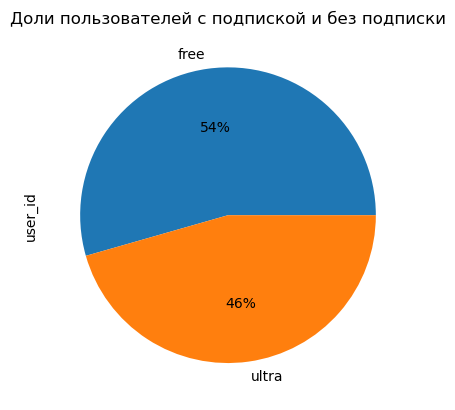

In [58]:
users.groupby('subscription_type')['user_id']\
    .count()\
    .plot(kind='pie', autopct='%1.0f%%', title='Доли пользователей с подпиской и без подписки')
plt.show()

In [59]:
users_subscription = users.pivot_table(index='city', 
                  columns ='subscription_type', 
                  values='user_id', aggfunc='count')
     
users_subscription

subscription_type,free,ultra
city,,
Екатеринбург,112,92
Краснодар,112,81
Москва,84,84
Омск,92,91
Пятигорск,125,94
Ростов-на-Дону,109,89
Сочи,103,86
Тюмень,98,82


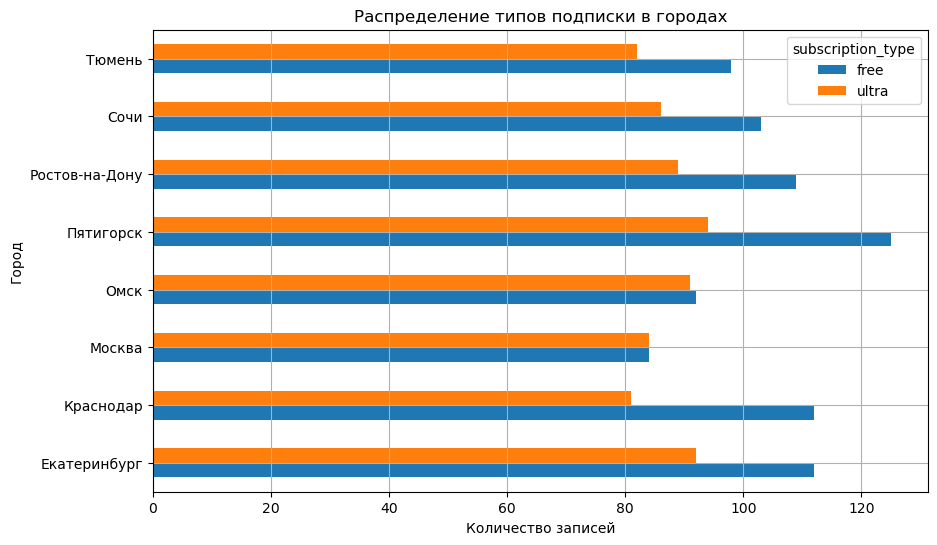

In [60]:
users_subscription.plot(kind='barh', figsize=(10, 6), grid=True)
plt.title('Распределение типов подписки в городах')
plt.xlabel('Количество записей')
plt.ylabel('Город')
plt.show()

Более половины всех пользователей сервиса - 54% не используют подписку. Доля пользователей, оформивших подписку составляет 46%.

Распределение по городам показало, что клиенты из Москвы и Омска с подпиской и без разделились практически поровну. В остальных городах: Тюмени, Сочи, Ростове-на-Дону, Пятигорске, Краснодаре и Екатеринбурге - преобладают пользователи, предпочитающие не оформлять подписку на сервис.

### Возраст пользователей

Определим средний возраст пользователей и построим гистограмму распределения клиентов сервиса по возрастам.

In [65]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

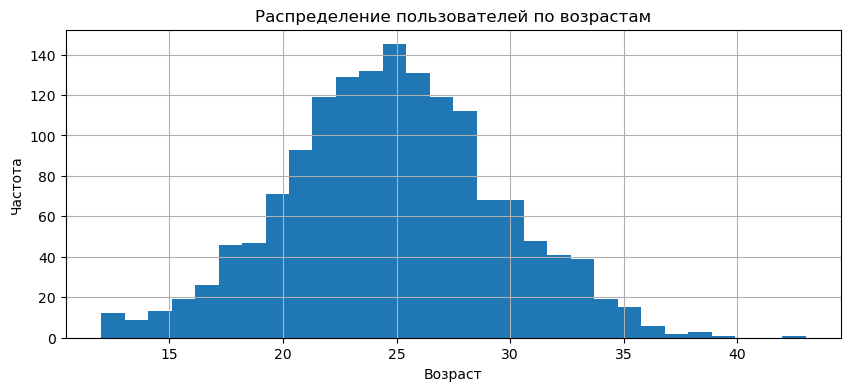

In [67]:
#users['age'].hist(bins=30, figsize=(10,4), grid=True, title='Распределение пользователей по возрастам')
users['age'].plot(kind='hist', bins=30, figsize=(10, 4), grid=True)
plt.title('Распределение пользователей по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

Клиентам сервиса от 12 до 43 лет. Средний возраст пользователя 25 лет, основная группа пользователей от 22 до 28 лет. Распределение клиентов по возрастам имеет вид нормального распределения.

### Расстояние, которое пользователь преодолел за одну поездку

Оценим расстояние, преодолеваемое за одну поездку, построим график распределения 

In [71]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

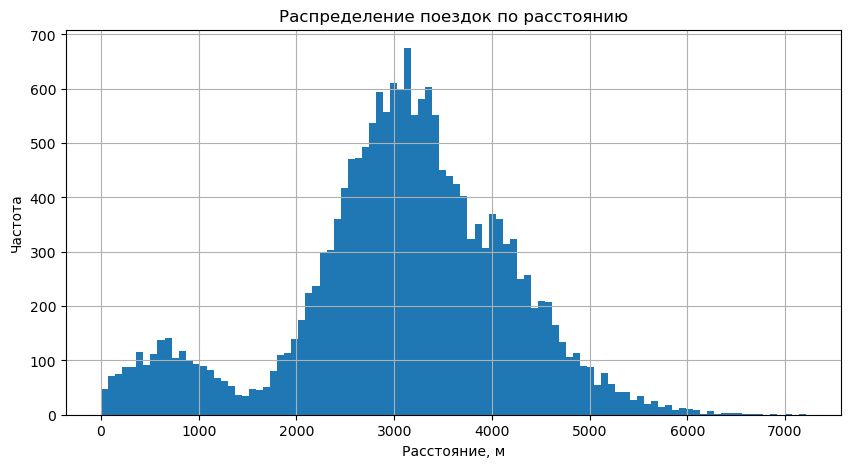

In [72]:
rides['distance'].plot(kind='hist', bins=100, grid=True, figsize=(10, 5))
plt.title('Распределение поездок по расстоянию')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.show()

Пользователи совершали поездки длиной от 1 м до 7 км. Среднее расстояние за одну поездку составляет 3071м. Медианное значение близко к среднему, составляет 3134м. 

Расстояние поездок распределено неравномерно. По графику можно условно выделить два типа поездок:
* короткие поездки, с расстоянием от 0 до 1,5 км. Пик значений составляет около 500 метров. Это небольшая доля всех поездок.
* длинные поездки, основная группа - поездки от 1,5 до 6 км. Пик значений составляет около 3200 метров. Таких поездок большинство. 
* Поездки свыше 6 км совершаются редко. 

Расстояние за одну поездку зависит от многих факторов. Для части клиентов аренда самоката может быть регулярной заменой общественному транспорту и такси - такие поездки могут быть длиннее. Для других -  способом добраться от дома до метро или от остановки автобуса до работы, такие поездки будут короче. Для кого-то это способ приятно провести время за прогулкой, например, в парке, - такие поездки могут быть существенно длиннее остальных. 

### Продолжительность поездок

Оценим продолжительность поездок пользователей сервиса. Построим гистограмму распределения поездок по длительности сессии.

In [77]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

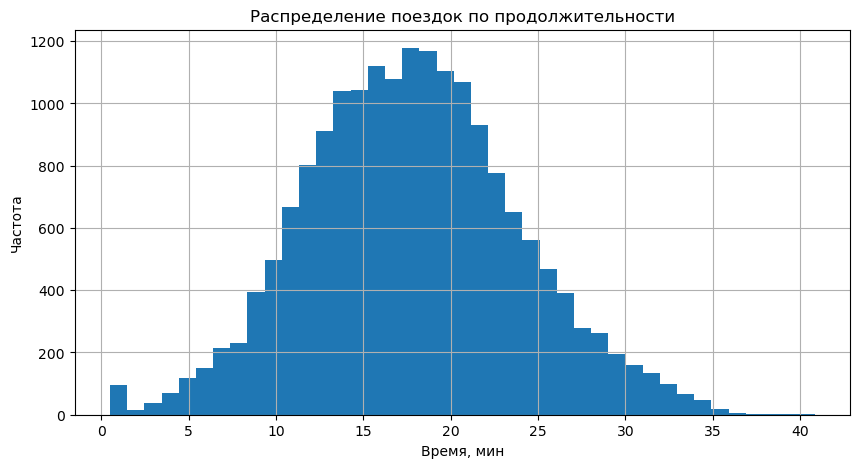

In [78]:
rides['duration'].plot(kind='hist', bins=41, grid=True, figsize=(10, 5))
plt.title('Распределение поездок по продолжительности')
plt.xlabel('Время, мин')
plt.ylabel('Частота')
plt.show()

Часть поездок пользователей длилась менее 1 минуты, рассмотрим подробнее эти данные.

In [80]:
rides.query('duration < 1').sort_values(by='distance')

,user_id,distance,duration,date,month
15132,1325,4030.308008,0.5,2021-12-22,12
17909,1524,4103.998874,0.5,2021-06-18,6
10692,1006,4106.278268,0.5,2021-10-31,10
9698,937,4169.066800,0.5,2021-12-12,12
14342,1268,4177.139336,0.5,2021-06-09,6
...,...,...,...,...,...
14574,1285,6316.574814,0.5,2021-09-25,9
13701,1224,6414.516026,0.5,2021-07-15,7
11385,1057,6601.197575,0.5,2021-02-07,2
17242,1477,6724.932981,0.5,2021-01-12,1


<div class="alert alert-block alert-info">

В датафрейме обнаружено 95 записей о поездках длительностью 0,5 минуты с расстоянием от 4 до 7 км. Стоит уточнить у коллег информацию о рекламных акциях с бесплатными минутами.

</div>

Пользователи сервиса совершали поездки продолжительностью от 30 секунд до 41 минуты.
* Большинство поездок длятся от 10 до 25 минут 
* Среднее время поездки 18 минут
* В данных присутствует 95 записей о поездках длительностью 0,5 минуты с расстоянием от 4 до 7 км. 
* Есть редкие поездки длительностью свыше 35 минут - это малая часть всех поездок
* Распределение поездок по длительности имеет вид нормального распределения.

## Объединение данных

### Объединим данные о пользователях, поездках и подписках в один датафрейм

In [88]:
# Количество строк в таблице rides после удаления выбросов
rides.shape[0]

18068

In [91]:
data = users.merge(rides, on='user_id').merge(subscriptions, on='subscription_type')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


In [92]:
data.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Новая таблица "data" содержит объединенные данные о пользователях, поездках и типах подписки. В таблице 17973 записи, пропущенных значений нет.

### Создадим датафрейм c данными о пользователях без подписки

In [95]:
free_users = data.query('subscription_type == "free" ')
free_users.sample(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
13557,1214,Савелий,25,Ростов-на-Дону,free,3425.939822,17.341300,2021-06-07,6,8,50,0
13167,1187,Влад,17,Москва,free,2466.566527,22.332833,2021-11-10,11,8,50,0
8220,827,Алиса,28,Краснодар,free,3021.607674,15.945882,2021-12-17,12,8,50,0
6575,705,Елена,27,Ростов-на-Дону,free,2570.516947,21.282068,2021-03-01,3,8,50,0
8182,825,Борис,27,Сочи,free,3038.908525,20.575865,2021-03-15,3,8,50,0
11229,1046,Всеволод,22,Омск,free,3355.576218,21.753677,2021-07-29,7,8,50,0
16900,1451,Иван,21,Тюмень,free,1205.825119,6.255853,2021-07-19,7,8,50,0
7676,784,Светлана,30,Ростов-на-Дону,free,1683.200864,17.312003,2021-04-07,4,8,50,0
8092,818,Антонина,24,Пятигорск,free,2259.006813,9.530023,2021-03-18,3,8,50,0
13551,1214,Савелий,25,Ростов-на-Дону,free,3448.704638,13.958549,2021-01-27,1,8,50,0


In [96]:
free_users.shape[0]

11568

Датафрейм 'free_users' о пользователях без подписки содержит 11473 записи.

### Создадим датафрейм c данными о пользователях с подпиской

In [99]:
ultra_users = data.query('subscription_type == "ultra" ')
ultra_users.sample(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
4759,512,Мария,29,Омск,ultra,2740.539336,20.277023,2021-05-31,5,6,0,199
2993,321,Артемий,22,Москва,ultra,2385.776958,22.543108,2021-04-15,4,6,0,199
4519,487,Николай,22,Екатеринбург,ultra,4067.689204,21.762454,2021-07-19,7,6,0,199
1170,125,Андрей,20,Тюмень,ultra,2629.937807,17.069087,2021-08-25,8,6,0,199
3447,371,Владислава,28,Екатеринбург,ultra,2988.165462,25.299084,2021-12-24,12,6,0,199
1167,125,Андрей,20,Тюмень,ultra,3361.636790,24.205456,2021-05-22,5,6,0,199
2016,218,Михаил,23,Сочи,ultra,3241.509809,19.960815,2021-08-01,8,6,0,199
289,30,Кира,29,Краснодар,ultra,3806.459819,12.929895,2021-10-01,10,6,0,199
3217,348,Татьяна,27,Ростов-на-Дону,ultra,2756.702204,16.876292,2021-10-12,10,6,0,199
3889,418,Наташа,26,Краснодар,ultra,4392.166693,28.470625,2021-04-28,4,6,0,199


In [100]:
ultra_users.shape[0]

6500

Датафрейм 'ultra_users' о пользователях с подпиской содержит 6500 записей.

### Расстояние и время поездок для пользователей обеих категорий

Построим гистограммы расстояния за одну поездку для пользователей с подпиской и без подписки.

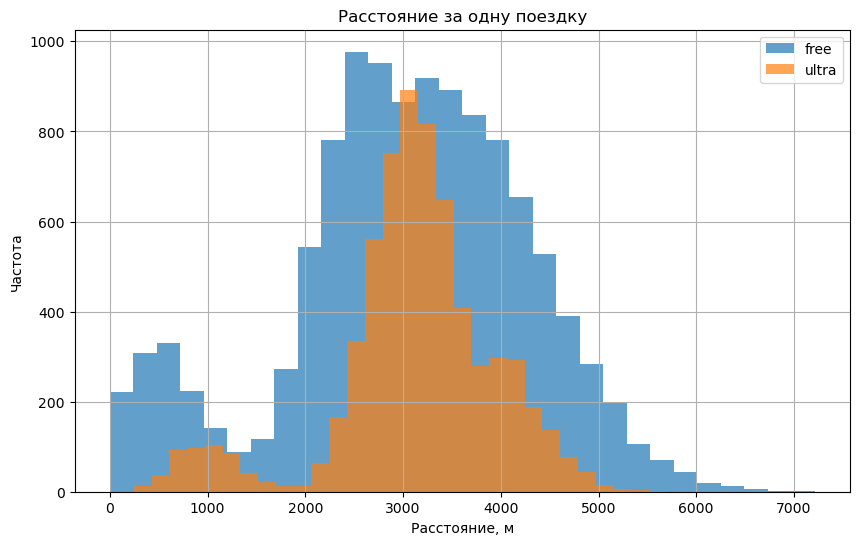

In [105]:
ax = free_users.plot(
    kind='hist', 
    bins=30,
    y='distance', 
    alpha=0.7, 
    label='free',
    figsize=(10, 6),
)
ultra_users.plot(
    kind='hist', 
    bins=30,
    y='distance', 
    alpha=0.7, 
    label='ultra',
    ax=ax,
    grid=True,
    legend=True,
)
plt.title('Расстояние за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.show()

In [106]:
print('Среднее расстояние одной поездки пользователей без подписки:', round(free_users['distance'].mean()), 'метров')
print('Среднее расстояние одной поездки пользователей с подпиской:', round(ultra_users['distance'].mean()), 'метров')

Среднее расстояние одной поездки пользователей без подписки: 3045 метров
Среднее расстояние одной поездки пользователей с подпиской: 3115 метров


Среднее расстояние одной поездки пользователей с подпиской и без отличается незначительно и составляет 3115 и 3045 метров соответственно.

Пользователи без подписки совершают значительно больше коротких поездок, на расстояние до 1 км. Возможно это новые клиенты сервиса. 
Пользователи без подписки совершают более длинные поездки, максимальное расстояние одной поездки свыше 7км против ~ 5,8км у пользователей с подпиской.

Построим гистограммы продолжительности поездки для пользователей с подпиской и без подписки.

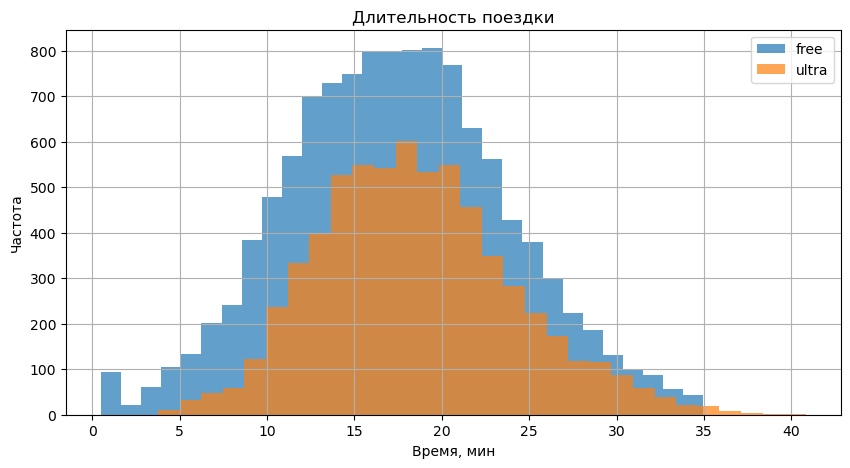

In [109]:
ax = free_users.plot(
    kind='hist', 
    bins=30,
    y='duration', 
    alpha=0.7, 
    label='free',
    figsize=(10, 5),
)
ultra_users.plot(
    kind='hist', 
    bins=30,
    y='duration', 
    alpha=0.7, 
    label='ultra',
    ax=ax,
    grid=True,
    legend=True,
)
plt.title('Длительность поездки')
plt.xlabel('Время, мин')
plt.ylabel('Частота')
plt.show()

In [110]:
print('Средняя продолжительность поездки пользователей без подписки:', round(free_users['duration'].mean()), 'минут')
print('Средняя продолжительность поездки пользователей с подпиской:', round(ultra_users['duration'].mean()), 'минут')

Средняя продолжительность поездки пользователей без подписки: 17 минут
Средняя продолжительность поездки пользователей с подпиской: 19 минут


Средняя длительность поездки пользователей без подписки и с подпиской отличается и составляет 17 и 19 минут соответственно. 
Среди пользователей с подпиской есть те, кто совершают более долгие поездки - свыше 40 минут, в то время как максимальная длительность поездки клиентов без подписки не превышает 35 минут. В группе пользователей без подписки есть пик значений времени в районе около 1 минуты. Возможно это новые пользователи, совершающие пробные поездки.

## Подсчёт выручки

### Округлим до следующего целого значения в колонках "расстояние" и "продолжительность сессии"

In [118]:
data['distance'] = np.ceil(data['distance']).astype(int)
data['duration'] = np.ceil(data['duration']).astype(int)

### Создадим датафрейм с агрегированными данными о поездках

Проверим, нет ли в датафрейме пользователей с двумя типами подписки одновременно.

In [122]:
data.groupby('user_id')['subscription_type'].unique().count() == data.groupby('user_id')['user_id'].unique().count()

True

In [123]:
data_agg = data.pivot_table(index=['user_id','month'], 
                            values=('date', 
                                    'distance', 
                                    'duration', 
                                    'subscription_type', 
                                    'minute_price', 
                                    'start_ride_price', 
                                    'subscription_fee'), 
                            aggfunc={'date':'count',
                                     'distance':'sum',
                                     'duration': 'sum',
                                     'subscription_type':'first',
                                     'minute_price':'first',
                                     'start_ride_price':'first',
                                     'subscription_fee':'first'
                                    }).reset_index().rename(columns={'date':'count'})

# добавим столбец с помесячной выручкой, которую принёс каждый пользователь
data_agg['revenue'] = (data_agg['start_ride_price'] * data_agg['count']
                       + data_agg['minute_price'] * data_agg['duration']
                       + data_agg['subscription_fee'])

data_agg.head(10)

,user_id,month,count,distance,duration,minute_price,start_ride_price,subscription_fee,subscription_type,revenue
0,1,1,2,7028,42,6,0,199,ultra,451
1,1,4,1,755,7,6,0,199,ultra,241
2,1,8,2,6724,46,6,0,199,ultra,475
3,1,10,2,5811,32,6,0,199,ultra,391
4,1,11,3,7005,56,6,0,199,ultra,535
5,1,12,2,6753,28,6,0,199,ultra,367
6,2,3,3,10190,63,6,0,199,ultra,577
7,2,4,2,6165,40,6,0,199,ultra,439
8,2,6,1,3256,14,6,0,199,ultra,283
9,2,7,2,6781,48,6,0,199,ultra,487


Таблица data_agg содержит данные о поездках пользователей, сгруппированные по идентификатору пользователя и месяцу, в котором совершались поездки: 
- user_id - идентификатор пользователя;
- month - месяц поездки;
- count - количество поездок;
- distance - общее расстояние за месяц;
- duration - общая длительность поездок за месяц
- minute_price - стоимость одной минуты поездки по данной подписке;
- start_ride_price - стоимость начала поездки;
- subscription_fee - стоимость ежемесячного платежа;
- subscription_type - тип подписки;
- revenue - помесячная выручка (считается по формуле: стоимость старта поездки × количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки).

## Проверка гипотез

Мы получили данные о суммарном количестве времени на поездки, расстоянии, которое преодолел каждый пользователь за месяц, помесячной выручке. Нашей задачей будет проверка следующих гипотез:
* 1. Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 
* 2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.  Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
* 3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

### Тратят ли пользователи с подпиской больше времени на поездки?

Проверим следующие предположения:
* пользователи без подписки тратят меньшее или то же количество времени на поездки, что и пользователи с подпиской.
* пользователи с подпиской тратят больше времени на поездки.

Для проверки гипотезы используем данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки. Так как наши группы пользователей не зависят друг от друга, будем сравнивать средние двух генеральных совокупностей, используя t-test для двух независимых групп.

Сформулируем гипотезы:
* Н0: средняя продолжительность поездки пользователей с подпиской равна продолжительности поездки пользователей без подписки;
* Н1: средняя продолжительность поездки пользователей с подпиской больше, чем у пользователей без подписки.

Возьмем уровень значимости равный 5%

In [131]:
alpha = 0.05
results = st.ttest_ind(ultra_users['duration'], free_users['duration'], alternative='greater')

print('p-value=', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value= 1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [132]:
# проверим, используя средние значения для каждой группы
print('Среднее время для пользователей с подпиской', ultra_users['duration'].mean())
print('Среднее время для пользователей без подписки', free_users['duration'].mean())

Среднее время для пользователей с подпиской 18.54198516280583
Среднее время для пользователей без подписки 17.39090929866399


Полученное значение p-value меньше заданного уровня значимости, собственно оно стремится к нулю. Значит у нас нет оснований предполагать, что пользователи с подпиской тратят меньше или столько же времени на поездки, что и пользователи без подписки. Будем считать, что пользователи с подпиской тратят больше времени на поездки. В таком случак можно предположить, что эта группа пользователей может быть "выгоднее" для компании.

### Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Проверим следующие предположения:
* Н0: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, составляет 3130 метров или меньше;
* Н1: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров.

Будем использовать односторонний t-тест для одной выборки. Уровень значимости возьмем равным 5%.

In [136]:
alpha = 0.05
control_value = 3130

results = st.ttest_1samp(
          ultra_users['distance'],
          control_value, 
          alternative='greater')

print('p-value=', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value= 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


In [137]:
# проверим, используя средние значения для каждой группы
print('Среднее расстояние для пользователей с подпиской', ultra_users['distance'].mean())

Среднее расстояние для пользователей с подпиской 3115.4453880370247


Исследование не подтвердило, что пользователи с подпиской за одну поездку проезжают больше 3130 метров. И так как это расстояние оптимальное с точки зрения износа самоката, можно сделать вывод, что пользователи с подпиской и в этом случае "выгодны" компании.

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? 

Проверим следующие предположения:
* Помесячная выручка от пользователей с подпиской не превышает выручку от пользователей без подписки;
* Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

Для проверки предположения используем данные о выручке по месяцам для каждой группы пользователей. Используя гипотезу о равенстве средних, проведем t-тест для двух независимых групп. Уровень значимости возьмем равным 5%.

Сформулируем гипотезы:
* Н0: средняя выручка от пользователей с подпиской равна средней выручке от пользователей без подписки;
* Н1: средняя выручка от пользователей с подпиской больше чем от пользователей без подписки.

In [141]:
free_users_revenue = data_agg.query('subscription_type == "free" ')['revenue'] # выручка от пользователей без подписки
ultra_users_revenue = data_agg.query('subscription_type == "ultra" ')['revenue'] # выручка от пользователей с подпиской

alpha = 0.05

results = st.ttest_ind(
          ultra_users_revenue, 
          free_users_revenue,
          alternative='greater')

print('p-value=', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value= 1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [142]:
# проверим, используя средние значения для каждой группы
print('Средняя выручка для пользователей с подпиской', ultra_users_revenue.mean())
print('Средняя выручка для пользователей без подписки', free_users_revenue.mean())

Средняя выручка для пользователей с подпиской 362.7921906022502
Средняя выручка для пользователей без подписки 328.6413651073845


Исследование не подтвердило, что что выручка от пользователей с подпиской меньше чем от пользователей без подписки. Значит можно предполагать обратное: пользователи с подпиской более выгодные для компании клиенты. 

### Выбор теста для проверки гипотезы об улучшениях мобильного приложения

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

В данном случае мы анализируем одну генеральную совокупность, с которой произошли некоторые изменения. Это одни и те же клиенты сервиса, использующие мобильное приложение до и после обновления серверов. Поэтому мы будем использовать гипотезу о равенстве средних для зависимых выборок.

В нашем случае мы будем проверять, равны ли средние количества обращений в техподдержку от одних и тех же клиентов до и после обновления серверов. 

<div class="alert alert-block alert-info">

Для проверки используем метод `ttest_rel()` из библиотеки scipy.stats

</div>

## Распределения

### Акция с раздачей промокодов на один бесплатный месяц подписки

Поможем отделу маркетинга GoFast решить следующую задачу: 

Нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Известно, что эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 

Подберем параметры распределения, описывающего эту ситуацию, построим график распределения и ответим на вопрос о количестве промокодов.

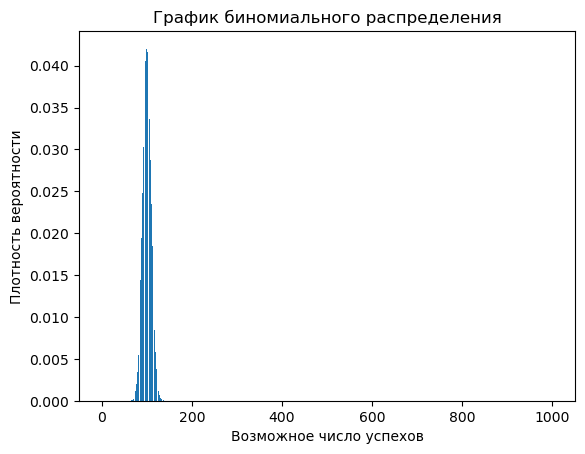

In [153]:
# Возьмем количество попыток равное 1000, вероятность успеха по условию равна 10%
n = 1000
p = 0.1

# Будем использовать биномиальное распределение
distr = []
for k in range (0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

# Построим график распределения: по горизонтальной оси отложим возможное число успехов, 
# а по вертикальной — вероятность соответствующего исхода. 
plt.bar(range(0, n + 1), distr)
plt.title('График биномиального распределения')
plt.xlabel('Возможное число успехов')
plt.ylabel('Плотность вероятности')
plt.show()

Минимальное количество успехов k - число продлений подписки должно быть равно 100. Вероятность не выполнить план - 5%. Предположим, что необходимое количество попыток n лежит в промежутке от 1000 до 1500. Цикл будет перебирать значения в этом интервале пока не доберется до первого необходимого количества попыток, когда вероятность неудачи будет менее 5%

In [159]:
for n in range (1000,1500):
    if binom.cdf(99, n, p) < 0.05:
        print("Минимальное количество попыток:", n)
        break

Минимальное количество попыток: 1161


Нужно разослать минимум 1161 промокод , чтобы вероятность не выполнить план была примерно 5 %.

### Оценка вероятности открытия push-уведомления

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Воспользуемся нормальной аппроксимацией биномиального распределения.

In [163]:
# Параметры биномиального распределения
n = 1000000 
p = 0.4

mu = n * p # мат.ожидание нормально расп. = мат. ожиданию биномиального расп.
sigma = sqrt(n * p * (1 - p)) # стандартное отклонение нор. расп-я = станд. отклонению биномиального расп-я
# задаём нормальное распределение с математическим ожиданием 400000 и стандартным отклонением ~489.9
distr = st.norm(mu, sigma) 
# считаем вероятность получить значение <= x
x = 399500

result = distr.cdf(x)
result

0.15371708296369768

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет 15.37%

## Общий вывод

В процессе исследования были реализованы следующие действия:
- 1. Импортированы и изучены данные.


- 2. В процессе предобработки:
    - формат столбца `date` таблицы `rides` переведен в формат `datetime`;
    - добавлен столбец `month` c номером месяца;
    - из таблицы `users` удалены дубликаты;
    - значения в колонках с расстоянием и продолжительностью сессии округлены до целого числа;
    - таблицы проверены на наличие пропущенных значений.


- 3. Проведен исследовательский анализ данных:
    - изучена частота встречаемости городов: в датафрейме обнаружены записи о пользователях из восьми городов России. 14% всех пользователей из Пятигорска - это самый часто встречающийся город в таблице. Меньше всего записей о пользователях из Москвы - около 11%. Данные по городам распределены равномерно.
    - в результате исследования соотношения пользователей с подпиской и без подписки сделаны следующие выводы: Более половины всех пользователей сервиса - 54% не используют подписку. Доля пользователей, оформивших подписку составляет 46%. Распределение по городам показало, что клиенты из Москвы и Омска с подпиской и без разделились практически поровну. В остальных городах: Тюмени, Сочи, Ростове-на-Дону, Пятигорске, Краснодаре и Екатеринбурге - преобладают пользователи, предпочитающие не оформлять подписку на сервис.
    - Проанализирован средний возраст пользователей: Клиентам сервиса от 12 до 43 лет. Средний возраст пользователя 25 лет, основная группа пользователей от 22 до 28 лет. Распределение клиентов по возрастам имеет вид нормального распределения.
    - Исследовано расстояние, которое пользователь преодолел за одну поездку: Пользователи совершали поездки длиной от 1 м до 7 км. Среднее расстояние за одну поездку составило 3071м. Медианное значение близко к среднему, и составило 3134м. Выяснилось, что расстояние поездок распределено неравномерно. На графике определились два пика: короткие поездки, с расстоянием от 0 до 1,5 км. Пик значений составляет около 500 метров - небольшая доля от всех поездок. И длинные поездки, - от 1,5 до 6 км. Пик значений составляет около 3200 метров. Таких поездок большинство. Поездки свыше 6 км совершаются редко.
   
   <div class="alert alert-block alert-info">
    
   - При исследовании продолжительности поездок пользователей сервиса найдена аномалия: часть поездок пользователей длилась менее 1 минуты, но расстояние таких поездок составило от 4 до 7 километров. В целом, пользователи овершали поездки продолжительностью от 30 секунд до 41 минуты. Большинство поездок длятся от 10 до 25 минут, среднее время поездки - 18 минут. Есть редкие поездки длительностью свыше 35 минут - это малая часть всех поездок. Распределение поездок по длительности имеет вид нормального распределения.

</div> 
 
 
- 4. Для дальнейшего исследования данные о пользователях, поездках и подписках были объединены в один датафрейм, после чего выделена информация о пользователях с подпиской и без подписки.  Изучено расстояние и время поездок для пользователей обеих категорий, сделаны следующие выводы:
    
    - Средняя длительность поездки пользователей обеих групп отличается и составляет около 17 минут у пользователей без подписки и 19 минут для клиентов с подпиской. Среди пользователей с подпиской есть те, кто совершают более долгие поездки - свыше 40 минут, в то время как максимальная длительность поездки клиентов без подписки не превышает 35 минут. В данных о длительности поездок клиентов без подписки есть пик значений времени в районе около 1 минуты. Возможно это новые пользователи, совершающие пробные поездки.

- 5. Для подсчета выручки был создан датафрейм с агрегированными данными о поездках, куда был добавлен столбец с помесячной выручкой от каждого клиента.


- 6. Были проверены следующие гипотезы: 
    * 1. Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 
    * 2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.  Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
    * 3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Сделаны заключения о том, что пользователи с подпиской тратят больше времени на поездки. Среднее расстояние, которое они проезжают за одну поездку, не превышает оптимального с точки зрения износа самоката. Средняя выручка пользователей с подпиской не меньше, чем от пользователей без подписки, таким образом, группа пользователей с подпиской более "выгодная" для компании. А значит компании стоит продолжать развивать это направление.
